# Extracting the multimodal fingerprint of urban transportation networks
## Develop by [Luis G. Natera](https://luisnatera.com)
### Contact: nateraluis [at] gmail [dot] com

The data was downloaded using OSMnx, here we work with the already downloaded data, to work with new one please check [OSMnx documentation](https://osmnx.readthedocs.io/en/stable/)

In [1]:
import numpy as np
import networkx as nx
import osmnx as ox
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mpcol
import matplotlib.pyplot as plt
from matplotlib import rcParams
from itertools import product, combinations
from sklearn.cluster import KMeans


ox.config(data_folder='data', logs_folder='logs', 
          imgs_folder='imgs', cache_folder='cache', 
          use_cache=True, log_file=True, log_console=True)
%matplotlib inline

In [2]:
cities = {'Amsterdam':'Amsterdam, Netherlands',
          'Singapore':'Singapore, Singapore',
          'Phoenix':'Phoenix, Arizona, USA',
          'Copenhagen':'Copenhagen Municipality, Denmark',
          'Manhattan':'Manhattan, New York City, New York, USA',
          'LA':'Los Angeles, Los Angeles County, California, USA',
          'Barcelona':'Barcelona, Catalunya, Spain',
          'Bogota':'Bogotá, Colombia',
          'Mexico':'DF, Mexico',
          'Budapest':'Budapest, Hungary',
          'London':'London, England',
          'Beihai':'Beihai, China',
          'Portland':'Portland, Oregon, USA',
          'Detroit':'Detroit, Michigan, USA',
          'Jakarta':'Daerah Khusus Ibukota Jakarta, Indonesia'
          }

# 1.- Overlap profile
We used [OSMnx](https://github.com/gboeing/osmnx) to download the city data from OpenStreetMaps, the next functions download each type of network.  
We are using the [graph from polygon](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.core.graph_from_polygon) method from OSMnx. In case of error while downloading the data, please review the documentation.

In [3]:
def overlap_network(layers):
    """
    Create the overlap network from the different layers.
    The function takes a list of graphs as the different layers of the multilayer network and returns a new graph
    """
    O = nx.Graph()
    for G in layers:
        for i,j,data in G.edges(data=True):
            if O.has_edge(i,j):
                O[i][j]['weight'] += data['weight'] if 'weight' in data else 1.0
            else:
                O.add_edge(i, j, weight= data['weight'] if 'weight' in data else 1.0)
    return O

def overlap_degree_vectors (O, layers, weight=True):
    """
    Get the degree of the nodes in the different layers.

    Returns a dict where the keys are the nodes and the values are lists containing the degree in each layer.

    O Overlapping network
    layers list of layers as networkx graphs
    Weight True for calculate the weighted degree.

    Parameters
    ----------
    O : networkx graph
        Overlap network
    layers : list
        networkx graphs
    weight : Bolean
        True, calculate the weighted degree
    Returns
    -------
    degree_nodes_dict : dict
    """
    degree_nodes_dict = {}
    if weight==True:
        for n in O.nodes():
            deg_temp = []
            deg_temp.append(O.degree(n,weight='weight'))
            for G in layers:
                if n in G.nodes():
                    deg_temp.append(G.degree(n,weight='weight'))
                else:
                    deg_temp.append(0)
            degree_nodes_dict[n] = deg_temp
    else:
        for n in O.nodes():
            deg_temp = []
            deg_temp.append(O.degree(n))
            for G in layers:
                if n in G.nodes():
                    deg_temp.append(G.degree(n))
                else:
                    deg_temp.append(0)
            degree_nodes_dict[n] = deg_temp

    return degree_nodes_dict

## 1.2.- Get the data

In [6]:
data = {}
for name in cities.keys():
    G_drive_simple = nx.read_edgelist('../data/{}/simple/{}_drive_simple.txt'.format(name,name), nodetype=int)
    G_pedestrian_simple = nx.read_edgelist('../data/{}/simple/{}_pedestrian_simple.txt'.format(name,name), nodetype=int)
    G_bike_simple = nx.read_edgelist('../data/{}/simple/{}_bike_simple.txt'.format(name,name), nodetype=int)
    G_rail_simple = nx.read_edgelist('../data/{}/simple/{}_rail_simple.txt'.format(name,name), nodetype=int)

    G_Layers = [G_drive_simple, G_rail_simple, G_bike_simple, G_pedestrian_simple]

    O = overlap_network(G_Layers)
    nodes_degree_dict = overlap_degree_vectors(O, G_Layers, weight=False)
    data[name] = nodes_degree_dict

# 2.- Overlap Census

In [7]:
def overlap_census(nodes_degree_dict):
    all_node_degree_vector = list(nodes_degree_dict.values())
    census = {}
    for p in product((0, 1), repeat=len(all_node_degree_vector[0][1:])):
        val = 0
        for node in all_node_degree_vector:
            if list(p) == [1 if i else 0 for i in node[1:]]:
                val+=1
        census[str(p)] = val
    return census

In [8]:
overlap_to_df = {}
for name in cities:
    overlap_to_df[name] = overlap_census(data[name])
df = pd.DataFrame.from_dict(overlap_to_df)

In [9]:
com = [x for x in range(len(cities))]
norm = mpcol.Normalize(vmin=min(com), vmax=max(com), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.tab20)
color=[mapper.to_rgba(x) for x in com]

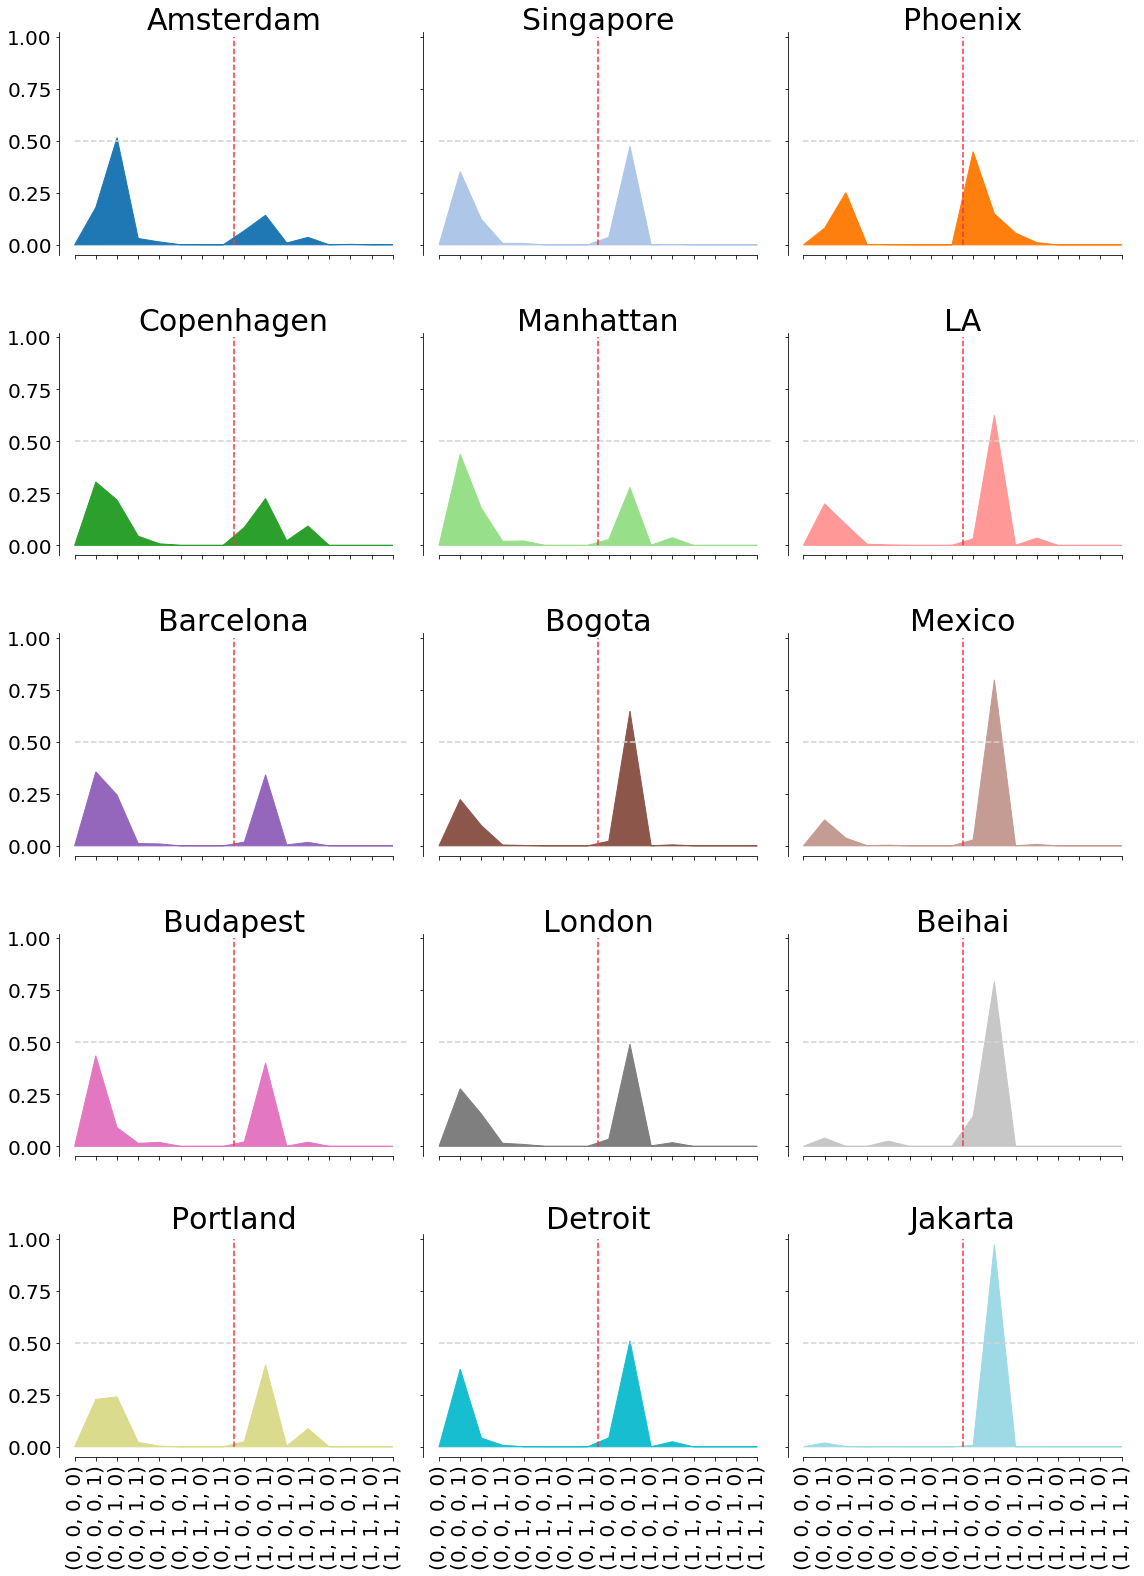

In [11]:
ci = [df.iloc[:,x] for x in range(len(cities))]

fig, axes = plt.subplots(5, 3, figsize=(16,22), sharex=True, sharey=True)
for ax, i, city, col in zip(axes.flat, range(len(cities)),cities, color):
    ax.hlines(0.5,0,31,colors='lightgray', linestyles='--')
    ax.vlines(7.5,0,1, colors='#f73842', linestyles='--')
    ax.fill(ci[i]/ci[i].sum(), color=col, alpha=1)
    ax.set_title(city, fontsize=30, pad=3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_smart_bounds(True)
    
for ax in fig.axes:
    plt.sca(ax)
    plt.yticks(ticks=[0.0,0.25,0.5,0.75,1.0], fontsize=20)
    plt.xticks(rotation=90, fontsize=20)
fig.tight_layout()
fig.subplots_adjust(hspace=0.35);

## 2.1.- Clusters 

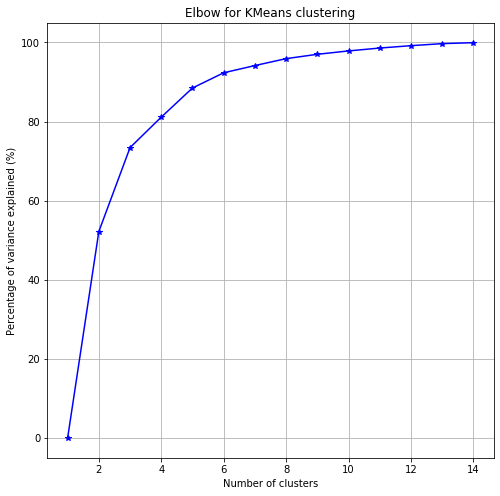

In [12]:
from scipy.spatial.distance import cdist, pdist

for i in cities:
    df[i]=df[i]/df[i].sum()
nodes = df.T
X = nodes.to_numpy()


Ks = range(1, len(nodes))
kmean = [KMeans(n_clusters=i, n_init=1000 ,max_iter=10000,random_state=123).fit(nodes) for i in Ks]

def plot_elbow(kmean, X):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering')
    plt.show()

plot_elbow(kmean, X)

In [13]:
nodes['cluster']=kmean[5].labels_
nodes['cluster'] = nodes['cluster']
nodes.sort_values('cluster',inplace=True)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


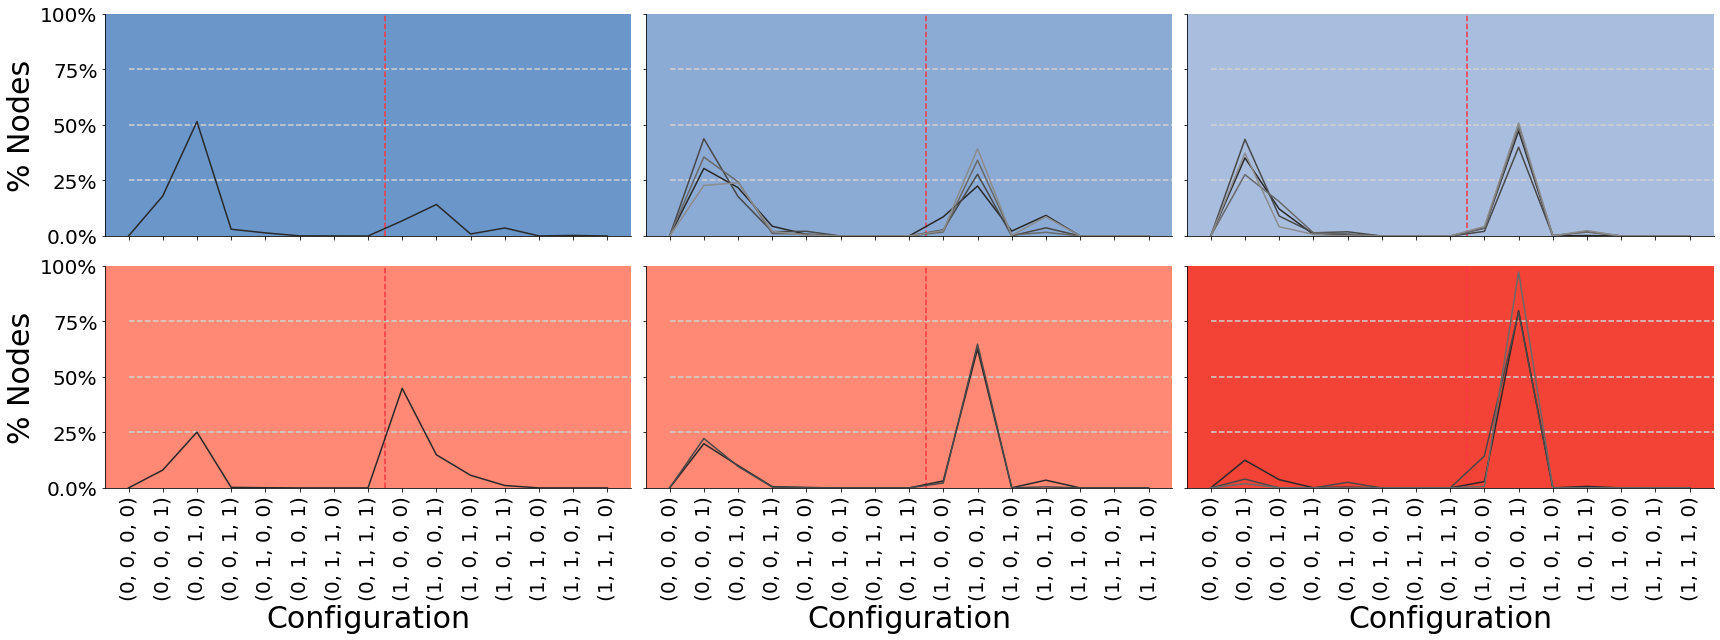

In [14]:
fig, axes = plt.subplots(2,3,figsize=(24,9), sharex=True, sharey=True)
colors = ['#292929','#484848','#696969','#8c8c8c','#b1b1b1','#d7d7d7','#ffffff']
colorsbg = ['#6b96ca','#8baad4','#a9bedf','#ff8975','#ff8975','#f34336']
iterate = [5,2,0,4,3,1]
for ax, i, colorbg in zip(axes.flat, iterate, colorsbg):
    df_temp = nodes.loc[nodes.cluster==i]
    ci = [df_temp.T.iloc[:-2,x] for x in range(len(df_temp))]
    ax.hlines(0.5,0,16,colors='lightgray', linestyles='--')
    ax.hlines(0.25,0,16,colors='lightgray', linestyles='--')
    ax.hlines(0.75,0,16,colors='lightgray', linestyles='--')
    ax.vlines(7.5,0,1, colors='#f73842', linestyles='--')
    plt.xticks(rotation=90, fontsize=35)
    ax.set_ylim(0,1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for c, col in zip(ci, colors):
        ax.plot(c, color=col,  alpha=1)
    ax.legend(frameon=False,fontsize=16,loc=1)
    ax.set_facecolor(colorbg)
    

for ax in fig.axes:
    ax.hlines(np.log(0.5),0,14,colors='lightgray', linestyles='--')
    ax.hlines(np.log(0.25),0,14,colors='lightgray', linestyles='--')
    ax.hlines(np.log(0.75),0,14,colors='lightgray', linestyles='--')
    plt.yticks(fontsize=20)
    plt.sca(ax)
    plt.yticks(ticks=[0.0,0.25,0.5,0.75,1],labels=['0.0%','25%','50%','75%','100%'], fontsize=20)
    plt.xticks(rotation=90, fontsize=20)
axes[0,0].set_ylabel('% Nodes', fontsize=30)
axes[1,0].set_ylabel('% Nodes', fontsize=30)
axes[1,0].set_xlabel('Configuration', fontsize=30)
axes[1,1].set_xlabel('Configuration', fontsize=30)
axes[1,2].set_xlabel('Configuration', fontsize=30)
plt.tight_layout();